In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# TODOs (from 09.06.2020)

1. Strip away the non-useful functions
2. Document the remaining functions
3. Move the remaining functions to modules
4. Test the modules
5. Clean up this NB

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [7]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

dsec = 1/3600.0
time = np.arange(0,24,dsec)


**Figure** in the above plot, time is on the "x"-axis. An interpretation of this motion, is that the user is initially making a "stay" at a location near $x=-1$, then makes another stay at $x=1$, ending with a return to the initial location. As with all of this data, there is an intrinsic noise that must be considered.

# Goal: Stay detection and positioning

The goal is to identify stays by their beginnings and ends, and associate them to a position. This effectively means to optimally match clusters of points with flat lines.

For a set of events within a cluster $\mathcal{C}_l =  \{e_i \; | \; i = [m,n]_l \subset [0,N-1]\}$, a "flat line" has $|\mathbf{x}_m-\mathbf{x}_n| = 0$. Again, this is easiest to see in 1D but it also holds in 2D.


# Strategy

To find the stays, we consider some requirements.

Firstly, there are two main requirements (previously noted):
1. identify the start/stop of a stay
2. estimate a dominant location, _ie_ the "central location" of the stay
    * this is where the agent spends the majority of the time, _e.g._ within a building, at a park, etc.

Then, there are some minor rquirements:
1. the clusters should contain a minimum number of points
2. the duration between the first and last points should exceed $\Delta t$
3. the clusters should be as long (in time) as possible
    * if there is a sufficient temporal break between two consecutive events without a significant location change, then on must specify how this is to be dealt with.
4. the clusters should contain as many events as possible

One additional requirement which affects all of the above: **cluster outliers should be identified and ignored** 
* outliers can change the central location and also the beginning/ending of the clusters
* from the calculation of the central location
    * counting them could still help in identifying a cluster wihtout using their position
    
All of these must be considered together.

This clearly defines an optimization problem: 
* maximize the length of the fit line, while 
    * mimimizing its error by adjusting its position ($\mathrm{x}_{\mathrm{opt.}}$) and end-regions ($t_{\mathrm{start}}, t_{\mathrm{stop}}$)
    * ignoring the outliers.

**Notes** 

* When the error is the mean squared error: $\epsilon := \sqrt{ \frac{1}{N}\sum^N_i(\mathrm{x}_i-\mathrm{x}_{\mathrm{opt.}})^2}$; 
    * this simplifies the position since the mean (or "centroid") is the value of $\mathrm{x}_{\mathrm{opt.}}$ which minimizes this error, leaving only the adjustment of the end-regions and outliers for the optimization task.

This suggests that there is at least a solution to this problem: 
One could consider all possible combinations of subsequences and all possible combinations of their outliers, and measure error, and then pick any from the set of lowest error subsequence-outlier combination fits. However, this is similar to the maximum subarray problem, and in the worst case it would be $\mathcal{O}(n^3)$.

It's countably finite, but impractical approach; itcan be a benchmark to compare all other algorithms which aim to do the same within some acceptable error.

### The Box

In [8]:
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [9]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [10]:
eps = 0.25

In [11]:
rand_range = lambda size, max_, min_: (max_-min_)*np.random.random_sample(size=size) + min_

In [12]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays, get_stay_indices
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [13]:
from synthetic_data.trajectory_class import get_trajectory

In [14]:
dsec = 1/3600.0
time = np.arange(0,24,dsec)

In [49]:
segs_plot_kwargs = {'linestyle':'--', 'marker':'o', 'color':'k', 'linewidth':4.0, 'markerfacecolor':'w', 'markersize':6.0, 'markeredgewidth':2.0, 'dashes':[2,0.5]}

In [16]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

### Load a saved trajectory

In [18]:
import pickle

In [19]:
from datetime import datetime

In [2]:
!ls *.pkl

20200625_trajectory_10stays__adjusted.pkl
20200625_trajectory_10stays.pkl
20200625_trajectory_8stays__adjusted.pkl


In [20]:
#pickle.dump( trajectory, open( trajectory_tag, "wb" ) )
trajectory = pickle.load( open( "20200625_trajectory_8stays__adjusted.pkl", "rb" ) )

In [22]:
trajectory.keys()

dict_keys(['segments', 'time_arr', 'raw_locs_arr', 'nse_locs_arr'])

In [23]:
time_sub, raw_journey_sub, noise_journey_sub = trajectory['time_arr'],trajectory['raw_locs_arr'],trajectory['nse_locs_arr']

In [24]:
new_stays = get_adjusted_stays(trajectory['segments'], time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays) 

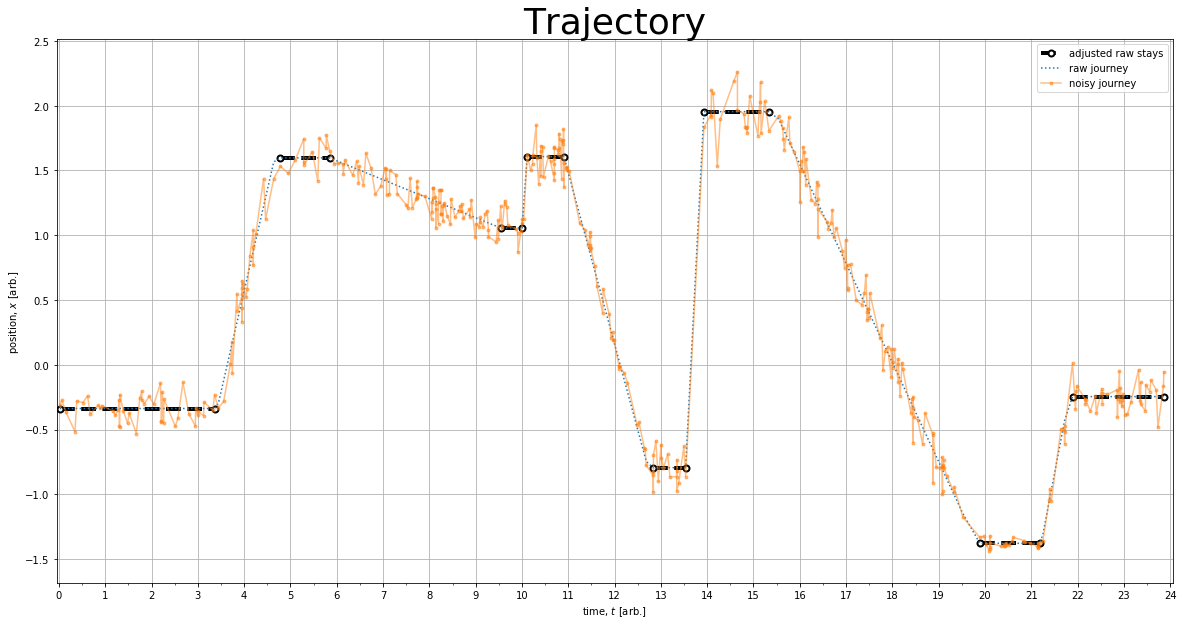

In [25]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

plt.legend();

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Trajectory', fontsize=36)
plt.grid(visible=True);

## Piecewise linear models

See 
[python-library-for-piecewise-regression](https://datascience.stackexchange.com/questions/8457/python-library-for-segmented-regression-a-k-a-piecewise-regression)

### Method 1

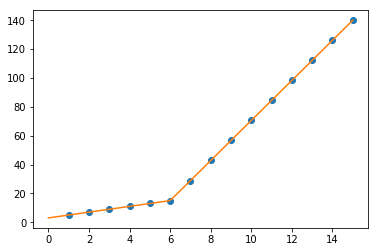

In [29]:
from scipy import optimize

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

lin_lamb = lambda x0, y0, k: lambda x: k*x + y0-k*x0

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lin_lamb(x0, y0, k1), lin_lamb(x0, y0, k2)])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

### Method 2

In [51]:
from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    
    # hyperparam
    nIterationMax = 20

    # Sorting the breaks
    breakpoints = np.sort( np.array(breakpoints) )

    # XDiffs
    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    # loop through the whole data set
    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
        # MJS: included
        breakpoints = breakpoints[(breakpoints > X.min()) & (breakpoints < X.max())]
        breakpoints = np.sort( np.array(breakpoints) )        
        
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution    

See: Muggeo, V. M. (2003). Estimating regression models with unknown breakpoints. _Statistics in medicine_, **22**(19), 3055-3071.

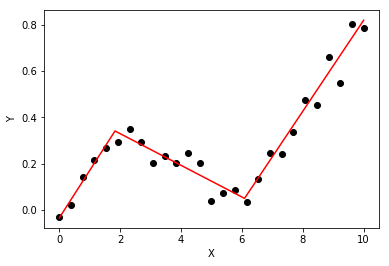

In [33]:
X = np.linspace( 0, 10, 27 )
Y = 0.2*X  - 0.3* ramp(X-2) + 0.3*ramp(X-6) + 0.05*np.random.randn(len(X))
plt.plot( X, Y, 'ok' );

initialBreakpoints = [1, 7]
plt.plot( *SegmentedLinearReg( X, Y, initialBreakpoints ), '-r' );
plt.xlabel('X'); plt.ylabel('Y');

### Method 3

3.054057507292176
[0.57  0.    0.    0.    0.    0.825 0.    0.    0.    0.    0.   ]


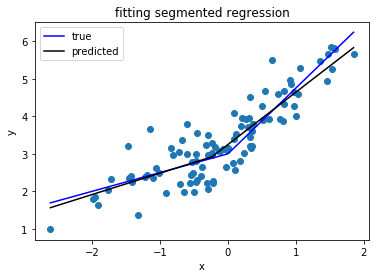

In [300]:
from sklearn.linear_model import Lasso
# generate data
np.random.seed(42)
x = np.sort(np.random.normal(size=100))
y_expected = 3 + 0.5 * x + 1.25 * x * (x>0)
y = y_expected + np.random.normal(size=x.size, scale=0.5)

# prepare a basis
k = 10
thresholds = np.percentile(x, np.linspace(0, 1, k+2)[1:-1]*100)
basis = np.hstack([x[:, np.newaxis],  np.maximum(0,  np.column_stack([x]*k)-thresholds)]) 

# fit a model
model = Lasso(0.03).fit(basis, y)

print(model.intercept_)
print(model.coef_.round(3))

plt.scatter(x, y)
plt.plot(x, y_expected, color = 'b')
plt.plot(x, model.predict(basis), color='k')
plt.legend(['true', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('fitting segmented regression')
plt.show()

**Note**
Due to Lasso approach, it is sparse: the model found exactly one breakpoint among 10 possible. Numbers 0.57 and 0.825 correspond to 0.5 and 1.25 in the true DGP.

0.07144167744762875
[ 0.087  0.    -0.    -0.    -0.    -0.14  -0.    -0.    -0.    -0.
  0.     0.     0.     0.241  0.     0.     0.     0.     0.     0.
  0.   ]


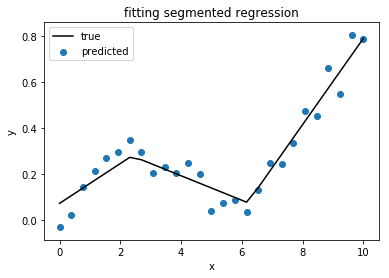

In [308]:
k = 20
thresholds = np.percentile(X, np.linspace(0, 1, k+2)[1:-1]*100)
basis = np.hstack([X[:, np.newaxis],  np.maximum(0,  np.column_stack([X]*k)-thresholds)]) 

# fit a model
model = Lasso(0.005, max_iter=2000).fit(basis, Y)

print(model.intercept_)
print(model.coef_.round(3))

plt.scatter(X, Y)
#plt.plot(X, y_expected, color = 'b')
plt.plot(X, model.predict(basis), color='k')
plt.legend(['true', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('fitting segmented regression')
plt.show()

## Breakdown of method 2

In [119]:
breakpoints0 = [p for p in new_t_segs[1:-2] if p != None]

In [ ]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

In [ ]:
# XDiffs
dt = np.min( np.diff(time_sub) )
ones = np.ones_like(time_sub)

In [122]:
breakpoints  = breakpoints0

In [123]:
Rk = [ramp( time_sub - xk ) for xk in breakpoints ] #computes slope leading to/from brakpoint
Sk = [step( time_sub - xk ) for xk in breakpoints ] #looks for breakpoint in the x-data

In [124]:
l0 = lambda x: 0*x if x != None else None
new_x_segs0 = np.array([l0(p) for p in new_x_segs])

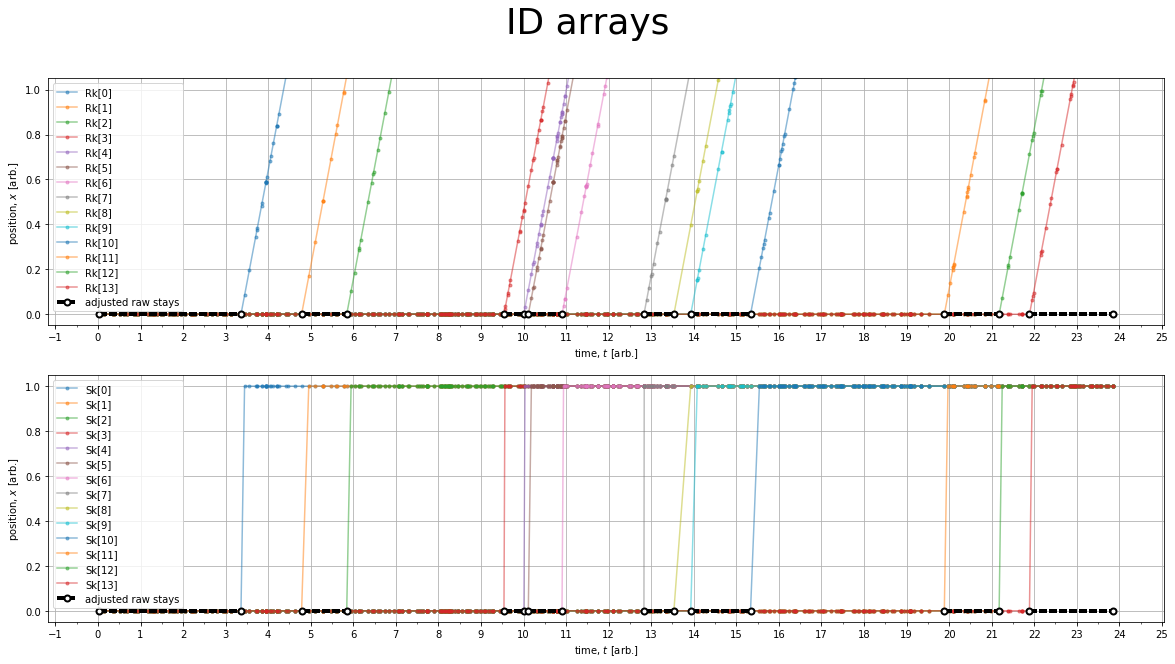

In [125]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')


ax =axs[0]
for n in range(len(Rk)):
    ax.plot(time_sub, Rk[n], '.-', label=f'Rk[{n}]', alpha=0.5)
ax.plot(new_t_segs, new_x_segs0, **segs_plot_kwargs, label='adjusted raw stays')


ax.legend();

ax.set_xlabel(r'time, $t$ [arb.]')
ax.set_ylabel(r'position, $x$ [arb.]')

ax.set_ylim(-0.05, 1.05)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.grid(visible=True);

ax =axs[1]
for n in range(len(Sk)):
    ax.plot(time_sub, Sk[n], '.-', label=f'Sk[{n}]', alpha=0.5)
ax.plot(new_t_segs, new_x_segs0, **segs_plot_kwargs, label='adjusted raw stays')


ax.legend();

ax.set_xlabel(r'time, $t$ [arb.]')
ax.set_ylabel(r'position, $x$ [arb.]')

ax.set_ylim(-0.05, 1.05)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.grid(visible=True);


fig.suptitle('ID arrays', fontsize=36);


### Applying the method

28.270248697512567 5.5555555555386606e-05 0.000277777777776933
11.002533057430579
0.6515916647819697 5.5555555555386606e-05 0.000277777777776933
23.40567511197306
0.7344208855825283 5.5555555555386606e-05 0.000277777777776933
153.30246628531276
5.7252442129139 5.5555555555386606e-05 0.000277777777776933
52.043794668672184
18.865162227999697 5.5555555555386606e-05 0.000277777777776933
57.74141601604655
17.714869316664494 5.5555555555386606e-05 0.000277777777776933
14.296084076460522
0.5925620814221801 5.5555555555386606e-05 0.000277777777776933
17.513252166587815
1.2587782107038752 5.5555555555386606e-05 0.000277777777776933
7.117285069347839
1.2479213820558712 5.5555555555386606e-05 0.000277777777776933
2.330223179744608
0.510912818686343 5.5555555555386606e-05 0.000277777777776933
1.2689071662305713
0.5500645839060425 5.5555555555386606e-05 0.000277777777776933
1.336447347173461
0.5701786605107948 5.5555555555386606e-05 0.000277777777776933
1.535946915267318
0.6832812242068336 5.55555

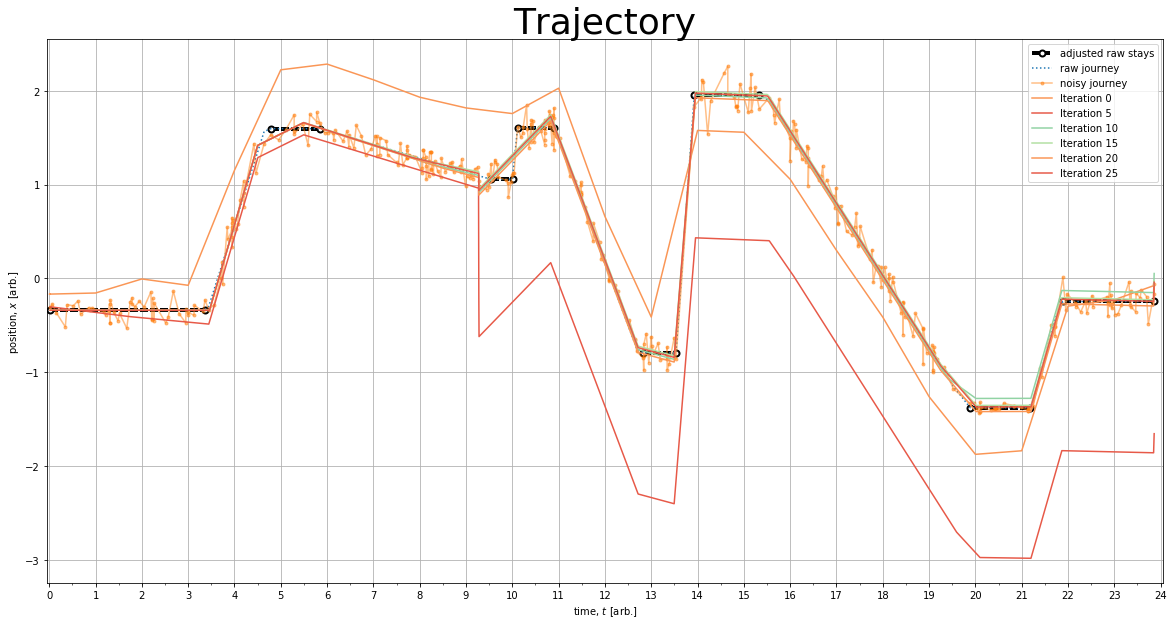

In [208]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

# hyperparam
nIterationMax = 30

# Sorting the breaks
breakpoints = np.sort( np.array(breakpoints0) )
breakpoints = np.arange(0,24,1)

# time_subDiffs
dt = np.min( np.diff(np.unique( time_sub)) )

ones = np.ones_like(time_sub)

yyysolution_last = noise_journey_sub

# loop through the whole data set
for i in range( nIterationMax ):
    
    #print(yyysolution_last.shape)
    
    ones = np.ones_like(time_sub)
    
    # Linear regression:  solve A*p = Y
    Rk = [ramp( time_sub - xk ) for xk in breakpoints ]
    Sk = [step( time_sub - xk ) for xk in breakpoints ]
    A = np.array([ ones, time_sub ] + Rk + Sk )
    p =  lstsq(A.transpose(), noise_journey_sub, rcond=None)[0] 

    # Parameters identification:
    a, b = p[0:2]
    ck = p[ 2:2+len(breakpoints) ]
    dk = p[ 2+len(breakpoints): ]

    # Estimation of the next break-points:
    newBreakpoints = breakpoints - dk/ck 

    print(np.max(np.abs(newBreakpoints - breakpoints)),dt/5, dt)
    # Stop condition
    if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
        print('Stopping criterion')
        #break
    
        
    # Compute the final segmented fit:
    xxxsolution = np.insert( np.append( breakpoints, max(time_sub) ), 0, min(time_sub) )
    ones =  np.ones_like(xxxsolution) 
    Rk = [ c*ramp( xxxsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    yyysolution = a*ones + b*xxxsolution + np.sum( Rk, axis=0 )

    # Compute the final segmented fit:
    ones_model =  np.ones_like(time_sub) 
    Rk_model = [ c*ramp( time_sub - x0 ) for x0, c in zip(breakpoints, ck) ]

    yyysolution_model = a*ones_model + b*time_sub + np.sum( Rk_model, axis=0 )
    
    print(np.linalg.norm(yyysolution_model-yyysolution_last))
    if np.linalg.norm(yyysolution_model-yyysolution_last) < 0.01:
        print(f'{i}: Stopping criterion #2')
        
    #print(yyysolution.shape)
    if i%5==0:
        plt.plot(xxxsolution, yyysolution, color=colors[i%len(colors)] , label=f'Iteration {i}')
    
    breakpoints = newBreakpoints
    breakpoints = breakpoints[(breakpoints > time_sub.min()) & (breakpoints < time_sub.max())]
    breakpoints = np.sort( breakpoints )
    
    yyysolution_last = yyysolution_model
    

plt.legend();

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
#plt.ylim(ymin, ymax)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Trajectory', fontsize=36)
plt.grid(visible=True);    

### Evaluation

In [215]:
calc_slope = lambda x1,y1,x2,y2: (y2-y1)/(x2-x1)

In [287]:
final_pairs = []
for n in range(0,len(yyysolution)-1,1):
    
    slope = calc_slope(xxxsolution[n],yyysolution[n],xxxsolution[n+1],yyysolution[n+1])
    
    print(slope)
    
    mask = np.where((time_sub >= xxxsolution[n]) & (time_sub < xxxsolution[n+1]))
    
    if abs(slope) < 0.1:
        final_pairs.append((mask[0][0],mask[0][-1]))

-0.00012906248626521325
1.688279765834101
0.9665209809327086
0.24476219624608464
-0.15878638702332445
-0.11880489206772615
-184.44418936802515
-91.96746084567464
0.5092676767906892
-1.3068172404865321
-0.1331970235720571
6.142571953235636
-0.019458858819205054
-0.3947594078376493
-0.7700599567433313
-0.6730429862193438
-0.5760260155057928
0.0010731025314909607
1.7193928762583943
-0.011385674463151682
16.775339155400676


In [288]:
final_pairs


[(0, 46), (258, 279), (370, 393), (403, 438)]

#### Evaluate

In [289]:
true_indices = get_stay_indices(new_stays, time_sub)

In [290]:
true_labels = np.zeros(time_sub.shape)

In [291]:
for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [292]:
np.sum(true_labels), true_labels.size-np.sum(true_labels), true_labels.size, np.sum(true_labels)/true_labels.size

(208.0, 233.0, 441, 0.47165532879818595)

In [293]:
pred_labels = np.zeros(time_sub.shape)
for pair in final_pairs:
    pred_labels[pair[0]:pair[1]+1] = 1

In [294]:
np.sum(pred_labels), pred_labels.size-np.sum(pred_labels), pred_labels.size, np.sum(pred_labels)/pred_labels.size

(129.0, 312.0, 441, 0.2925170068027211)

In [295]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [296]:
confusion_matrix(true_labels, pred_labels)

array([[232,   1],
       [ 80, 128]])

Thus in binary classification, the count of 
* true negatives is $C_{0,0}$, 
* false negatives is $C_{1,0}$, 
* true positives is $C_{1,1}$ and 
* false positives is $C_{0,1}$.

In [297]:
precision_score(true_labels, pred_labels), recall_score(true_labels, pred_labels), 

(0.9922480620155039, 0.6153846153846154)

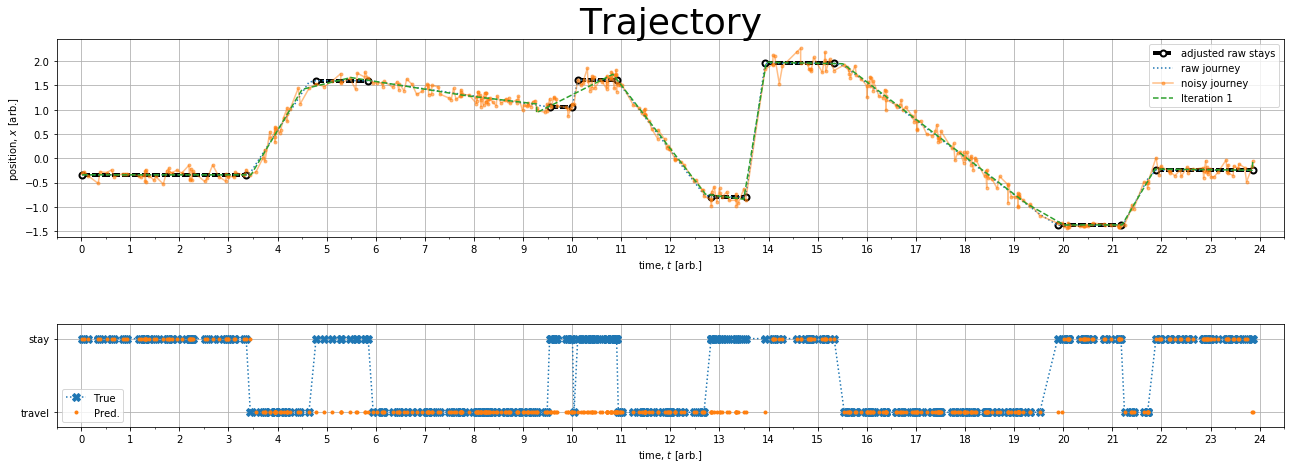

In [298]:
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax1.plot(time_sub, raw_journey_sub, ':', label='raw journey')
ax1.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
        
ax1.plot(xxxsolution, yyysolution, '--', label=f'Iteration {i}')
        

ax1.legend();

ax1.set_xlabel(r'time, $t$ [arb.]')
ax1.set_ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
#plt.ylim(ymin, ymax)

ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))

ax1.set_xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

ax1.set_title('Trajectory', fontsize=36)
ax1.grid(visible=True);    

ax2 = fig.add_subplot(2,1,2, adjustable='box', aspect=1.5, sharex=ax1)

ax2.plot(time_sub, true_labels, 'X:', markersize=8, label='True')
ax2.plot(time_sub, pred_labels, '.', label='Pred.')
ax2.set_ylim(-0.2,1.2)
ax2.set_xlim(-0.5,24.5)

'''ax = plt.gca()

ax2.xaxis.set_major_locator(MultipleLocator(1))

#ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
'''
plt.xlabel(r'time, $t$ [arb.]')

ax2.set_yticks([0,1])
ax2.set_yticklabels(['travel', 'stay'])
ax2.legend()
#ax2.set_title('Trajectory', fontsize=36)
ax2.grid(visible=True);    